In [171]:
import sys
# sys.path.append("/ubc/cs/research/kmyi/matthew/projects/evimo_formatter")
sys.path.append("/scratch/matthew/projects/ecam-cam-datapipline")

import os
os.chdir("/ubc/cs/research/kmyi/matthew/projects/evimo-formatter")
# from format_data.utils import EventBuffer
from ev_buffer import EventBuffer
# from format_data.eimg_maker import ev_to_eimg

import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import glob
import pandas as pd
import cv2

scene_path = "/ubc/cs/research/kmyi/matthew/projects/evimo-formatter/dev_est_scene_03_03_000002"
img_fs = sorted(glob.glob(osp.join(scene_path,"images/*.png")), key=lambda x: int(osp.basename(x.split('.')[0]).split("_")[-1]))
sumE_fs = sorted(glob.glob(osp.join(scene_path, "sumE/*.txt")), key=lambda x: int(osp.basename(x.split('.')[0]).split("_")[-1]))
sumP_fs = sorted(glob.glob(osp.join(scene_path, "sumP/*.txt")), key=lambda x: int(osp.basename(x.split('.')[0]).split("_")[-1]))
msk_fs = sorted(glob.glob(osp.join(scene_path, "msk/*.npy")), key=lambda x: int(osp.basename(x.split('.')[0]).split("_")[-1]))
img_ts = np.load("/ubc/cs/research/kmyi/matthew/projects/evimo-formatter/dev_est_scene_03_03_000002/frame_ts.npy")
# events_f = osp.join(scene_path, "events.csv") # events in x,y,t,p
# img_t_f = osp.join(scene_path, "images.txt")  # events in x,y,t,p
evs_src_dir = "/ubc/cs/research/kmyi/matthew/backup_copy/raw_real_ednerf_data/evimo2_v2_data/npz/samsung_mono/sfm/eval/scene_03_03_000002"


bias_f = "/ubc/cs/research/kmyi/matthew/projects/evimo-formatter/dev_est_scene_03_03_000002/bias.csv"
scale_f = "/ubc/cs/research/kmyi/matthew/projects/evimo-formatter/dev_est_scene_03_03_000002/scale.csv"
logSafetyOffset = 90

In [172]:
class calibBuffer(EventBuffer):
    def load_events(self, ev_dir):
        p_f = np.load(osp.join(ev_dir, "evs_ps.npy"))
        t_f = np.load(osp.join(ev_dir, "evs_ts.npy"))
        xys = np.load(osp.join(ev_dir, "evs_xys.npy"))
        x_f, y_f = xys[:,0], xys[:,1]

        return x_f, y_f, p_f, t_f
    
    def __len__(self):
        return len(self.t_f)

def ev_to_eimg(x, y, p, e_thresh=None, img_size = None):
    """
    input:
        evs (np.array [type (t, x, y, p)]): events such that t in [t_st, t_st + time_delta]
        img_size (tuple [int, int]): image size in (h,w)
    return:
        event_img (np.array): of shape (h, w)
    """
    e_thresh = 0.15
    if img_size is None:
        h, w = 720, 1280
    else:
        h, w = img_size

    pos_p = p==1
    neg_p = p==0

    e_img = np.zeros((h,w), dtype=np.int32)
    
    np.add.at(e_img, (y[pos_p], x[pos_p]), 1)
    np.add.at(e_img, (y[neg_p], x[neg_p]), -1)
    

    return e_img

In [173]:
idx = 200

img = cv2.imread(img_fs[idx], cv2.IMREAD_GRAYSCALE)
prev_img, next_img = cv2.imread(img_fs[idx], cv2.IMREAD_GRAYSCALE), cv2.imread(img_fs[idx+1],cv2.IMREAD_GRAYSCALE)
sume = np.loadtxt(sumE_fs[idx], delimiter=",")
sump = np.loadtxt(sumP_fs[idx], delimiter=",")
msk = np.load(msk_fs[idx])
buffer = EventBuffer(evs_src_dir)
bias, scale = np.loadtxt(bias_f, delimiter=","), np.loadtxt(scale_f, delimiter=",")

In [174]:
ts, xs, ys, ps = buffer.retrieve_data(img_ts[idx], img_ts[idx + 1])
cnt_img = ev_to_eimg(xs, ys, np.ones(len(xs)), img_size=img.shape[:2])
ecnt_img = ev_to_eimg(xs, ys, ps, img_size=img.shape[:2])

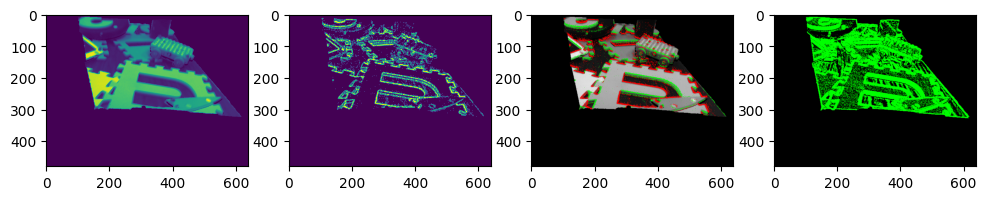

In [175]:
fig, axs = plt.subplots(1,4,figsize=(12,3))
comb_img = np.stack([img]*3, -1)
comb_img[sump != 0] = 0
comb_img[sump > 0, 1] = 255
comb_img[sump < 0, 0] = 255

img_diff = next_img - prev_img
diff_err = np.zeros((*next_img.shape, 3))
diff_err[img_diff < 0, 0] = 1
diff_err[img_diff > 0, 1] = 1
diff_err[np.abs(img_diff) < 0.024*255] = 0

axs[0].imshow(img)
axs[1].imshow(sume>0)
axs[2].imshow(comb_img)
axs[3].imshow(diff_err)

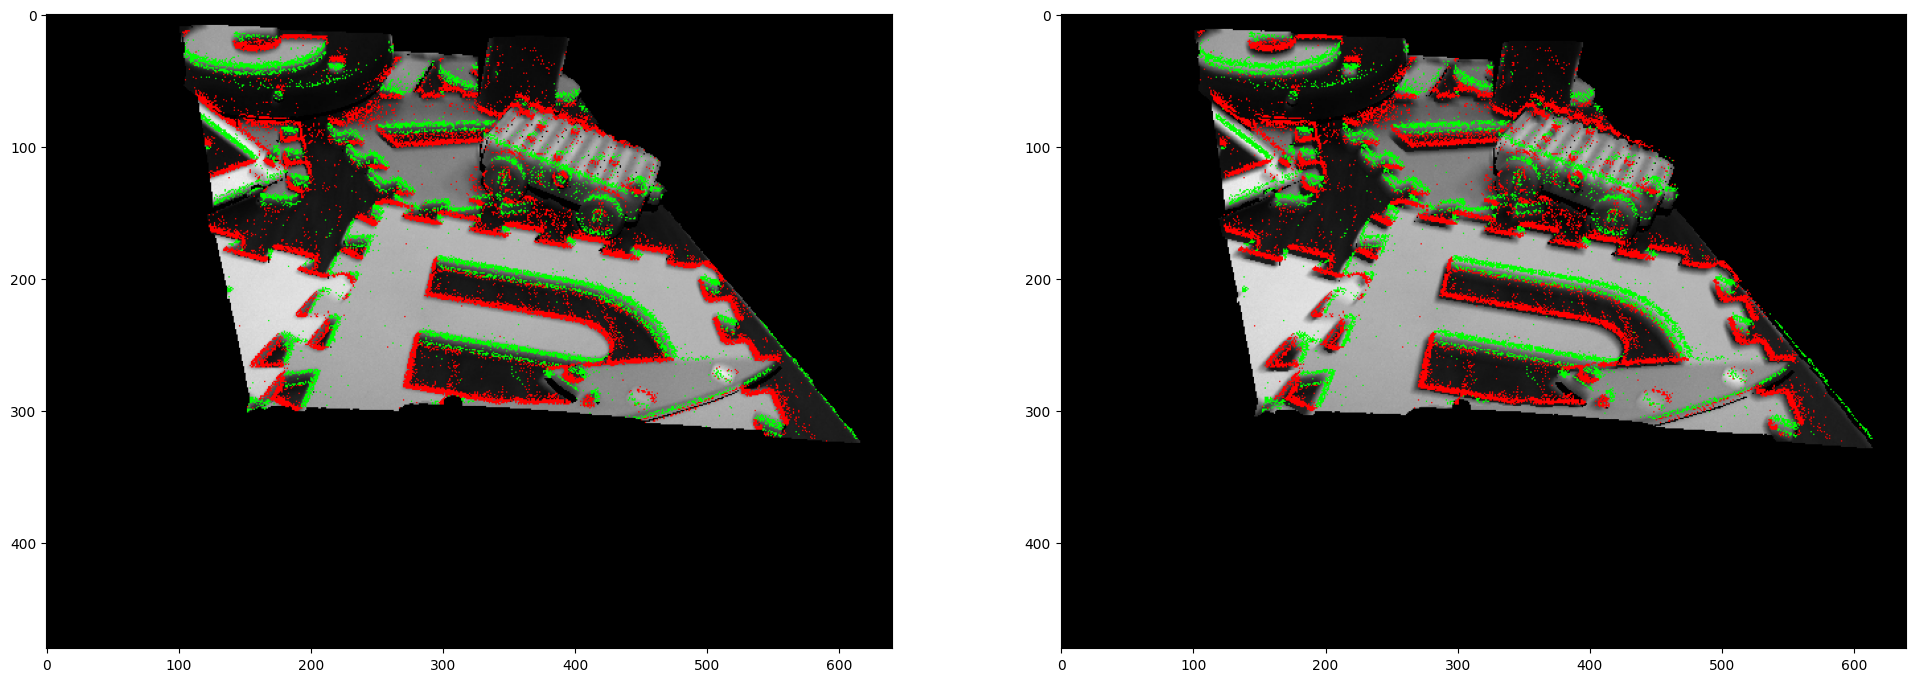

In [176]:
prev_comb_img = np.stack([prev_img]*3, -1)
prev_comb_img[sump != 0] = 0
prev_comb_img[sump > 0, 1] = 255
prev_comb_img[sump < 0, 0] = 255

next_comb_img = np.stack([next_img]*3, -1)
next_comb_img[sump != 0] = 0
next_comb_img[sump > 0, 1] = 255
next_comb_img[sump < 0, 0] = 255

fig, axs = plt.subplots(1,2, figsize=(24,12))
axs[0].imshow(prev_comb_img.astype(np.uint8))
axs[1].imshow(next_comb_img.astype(np.uint8))

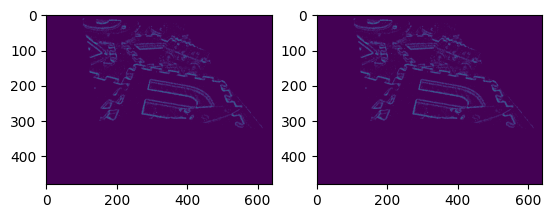

In [177]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(sume)
axs[1].imshow(cnt_img * msk)

In [178]:
prev_img, next_img = prev_img.astype(np.float32), next_img.astype(np.float32)
pos_cond = ps==1
neg_cond = ~pos_cond
pos_acc = ev_to_eimg(xs[pos_cond], ys[pos_cond], ps[pos_cond], img_size=img.shape[:2]) 
neg_acc = ev_to_eimg(xs[neg_cond], ys[neg_cond], np.ones(sum(neg_cond)), img_size=img.shape[:2])

pred_log = np.log(prev_img + logSafetyOffset) + pos_acc * (scale + bias) + neg_acc * (-scale + bias)
pred_img = np.round(np.exp(pred_log) - logSafetyOffset).astype(np.float32)

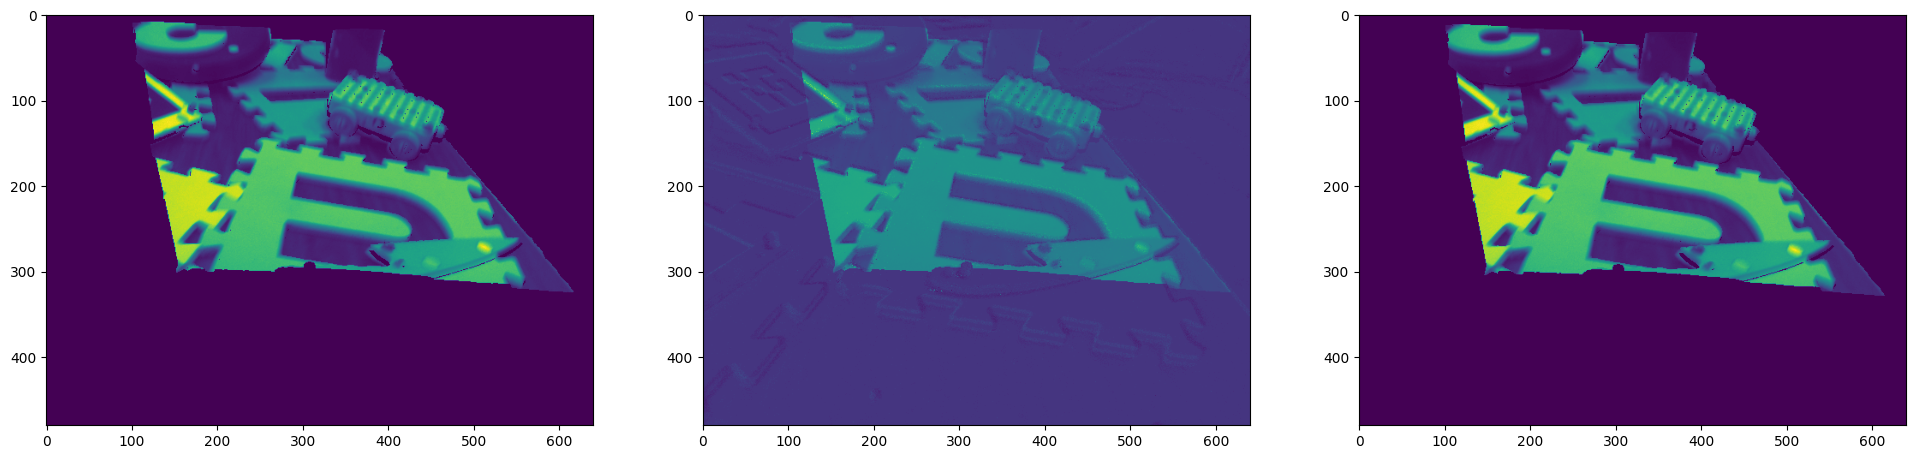

In [179]:
fig, axs = plt.subplots(1,3, figsize=(24,8))
# axs[0].imshow(prev_img)
# axs[1].imshow(pred_img)
axs[0].imshow(prev_img)
axs[1].imshow(pred_img)
axs[2].imshow(next_img)

In [180]:
calc_err = lambda x, y: ((x.astype(np.float32) - y.astype(np.float32)*msk)**2).mean()
print("base:", calc_err(prev_img, next_img), "pred:", calc_err(pred_img, next_img))

base: 353.06436 pred: 380.7998


In [181]:
calc_err = lambda x, y: ((x.astype(np.float32) - y.astype(np.float32))**2).mean()
print("base:", calc_err(prev_img, next_img), "pred:", calc_err(pred_img, next_img))

base: 528.0826 pred: 551.77484
